# Module 2 - Final Project - SQL and Statistical Significance

## Importing Required Libraries and Querying SQL DB

In [25]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from statsmodels.formula.api import ols
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import warnings 
from IPython.core.interactiveshell import InteractiveShell

conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
'''))

In [26]:
warnings.simplefilter('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [27]:
print(table_names)

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [28]:
sql_comm = []
for i in range(0, len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

# Reading in SQL Tables into Pandas Dataframes
employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)
orders = pd.read_sql_query('''SELECT * FROM [Order]''', conn)

# Product Pricing and Customer Incentives

## Question 1
__Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?__

$H_{o}$: The average quantity of product ordered is the same for normally priced orders and those with a discount

$H_{a}$: The average quantity of product ordered is not the same for normally prices orders and those with a discount, the quantity is either higher or lower

__Control Group__: Orders without any discounts applied, full price products sold
<br>
__Experimental Group__: Orders with discounts applied, products sold at lower than retail price

### Data Wrangling
Table: Order Details

In [30]:
order_details[['Quantity', 'Discount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


### Question 1a
<br>
Our primary question to address is whether discounting of products will impact the amount of product that Company X is selling. This is an important question to ask for sales, marketing, and product management teams in order for them to optimize their messaging, customer loyalty, and most importantly...the bottom line. If we are able to answer this question and determine at what levels of discounting results in the greatest uptick of customer orders/product deliveries, we can generate a larger profit and continue to grow our business.

__How:__ test our hypotheses with a two-tail test accounting for either an increase or decrease in products ordered as a result of discounts applied to said products.
<br>
__Table:__ Order Details
<br>
__Features:__ Quantity, Discount

__Control Group__: Orders without discount
<br>
__Experimental Group:__ Discounted product orders

In [259]:
order_details.Discount.value_counts().head()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
Name: Discount, dtype: int64

In [33]:
order_details['Discount_bin'] = order_details['Discount'].apply(lambda x: 1 if x > 0 else 0)

<BarContainer object of 2 artists>

Text(1, 10, '21.72')

Text(0, 10, '27.11')

Text(0, 0.5, 'Average Quantity')

Text(0.5, 1.0, 'Average Quantity of Product Per Order: Discount vs No Discount')

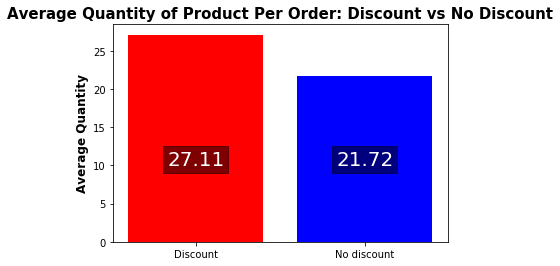

In [135]:
X = ['Discount', 'No discount']
y = [order_details['Quantity'][order_details['Discount_bin'] == 1].mean(),
order_details['Quantity'][order_details['Discount_bin'] == 0].mean()]
plt.bar(X, y, color=('red', 'blue'))
plt.text(s=round(y[1],2), x=1, y=10, color='w', horizontalalignment='center', size=20, 
         bbox=dict(facecolor='black', alpha=0.5))
plt.text(s=round(y[0],2), x=0, y=10, color='w', horizontalalignment='center', size=20, 
         bbox=dict(facecolor='black', alpha=0.5))
plt.ylabel('Average Quantity', fontsize=12, fontweight='bold')
plt.title('Average Quantity of Product Per Order: Discount vs No Discount', fontsize=15, fontweight='bold')

In [35]:
discount_control_group = order_details[order_details.Discount_bin == 0].Quantity
discount_experimental_group = order_details[order_details.Discount_bin == 1].Quantity

__Variance__

In [36]:
print('Control Group Variance:', discount_control_group.var())
print('Experimental Group Variance:', discount_experimental_group.var())
print('Difference', abs(discount_control_group.var() - discount_experimental_group.var()))

Control Group Variance: 306.51232768588454
Experimental Group Variance: 431.45268788690146
Difference 124.94036020101692


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Quantity Distribution of Products Sold')

Text(0.5, 0, 'Quantity of Product')

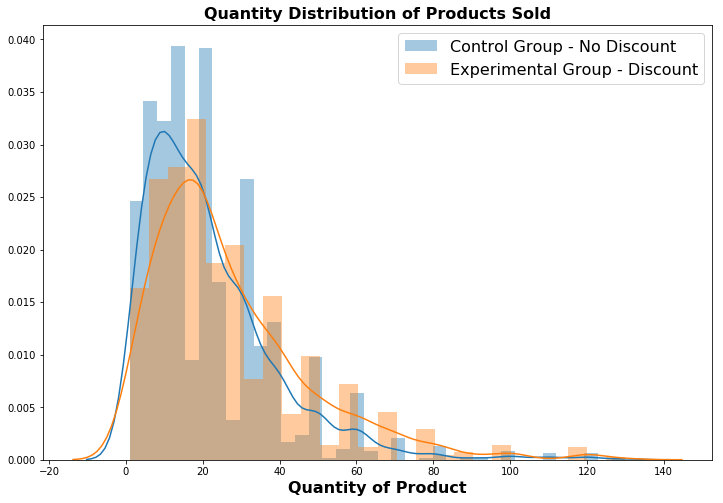

In [37]:
plt.figure(figsize=(12,8))
sns.distplot(discount_control_group, label='Control Group - No Discount')
sns.distplot(discount_experimental_group, label='Experimental Group - Discount')
plt.title('Quantity Distribution of Products Sold', fontsize=16, fontweight='bold')
plt.xlabel('Quantity of Product', fontsize=16, fontweight='bold')
plt.legend(fontsize=16)

__Distribution Analysis__

The above distribution plot shows right skewedness for both the control and experimental group (no discount and discounted product orders). This data differs from a Gaussian distribution, so we will need to decide on an approach to remediate. 

### Normality Test - Two-tailed - Statsmodels Normal Test

In [38]:
print('Normality of Control Group', stats.normaltest(discount_control_group))
print('Normality of Experimental Group', stats.normaltest(discount_experimental_group))

Normality of Control Group NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of Experimental Group NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

We saw above in the distributions that there is a difference between the two means of the control and experimental groups. Let's calculate that difference to determine the effect size of this data.

__Cohen's D - determining effect size__

- -1.0: Perfect negative relationship
- -0.7: Strong negative relationship
- -0.5: Moderate negative relationship
- -0.3: Weak negative relationship
- 0.0: No relationship
- 0.3: Weak positive relationship
- 0.5: Moderate positive relationship
- 0.7: Strong positive relationship
- 1.0: Perfect positive relationship

In [39]:
def Cohens_d(group1, group2):
    
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    pooled_var = (n1 * var1) + (n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    return d

print("Cohen's d:", Cohens_d(np.array(discount_experimental_group), np.array(discount_control_group)))

Cohen's d: 0.008974519957357523


This small effect size of 0.008 indicates very little difference between the means of the control and experimentals groups.

Now we have a t-value and variance value that we can use to calculate a p-value.

P-value: The probability of obtaining a test statistic at least as extreme as the one we observed if the null hypothesis is true

#### Create a new Sample Distribution

In [42]:
# create a random sample list
def create_sample(df, n):
    sample = []
    while len(sample) < n:
        x = np.random.choice(df)
        sample.append(x)
    return sample
# use random sample list to create a sample distribution in a dataframe
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = []
    while len(sample_dist) < dist_size:
        sample = create_sample(df, n)
        sample_mean = sum(sample)/len(sample)
        sample_dist.append(sample_mean)
    return sample_dist

In [43]:
control_sample = create_sample_distribution(discount_control_group)
experimental_sample = create_sample_distribution(discount_experimental_group)

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Quantity Sample Distribution of Products Sold')

Text(0.5, 0, 'Quantity of Product')

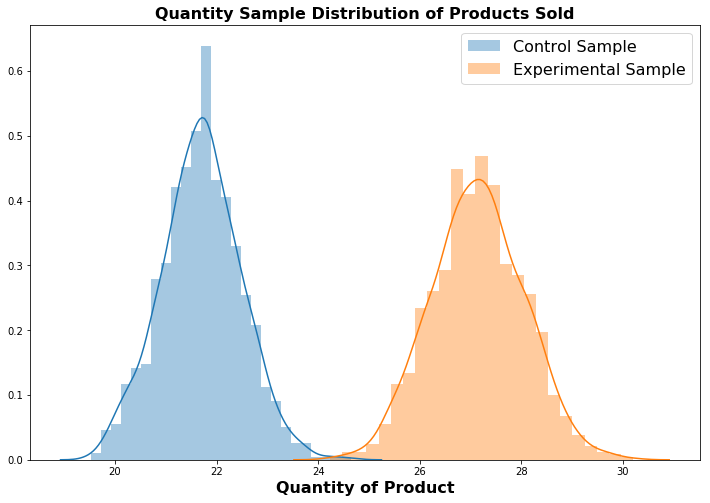

In [45]:
plt.figure(figsize=(12,8))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Quantity Sample Distribution of Products Sold', fontsize=16, fontweight='bold')
plt.xlabel('Quantity of Product', fontsize=16, fontweight='bold')
plt.legend(fontsize=16)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions. Now there is also a significant difference between the two means of the group but similar levels of variance.

__Cohen's D Effect Size__

In [258]:
print("Cohen's d:", Cohens_d(np.array(control_sample), np.array(experimental_sample)))

Cohen's d: -0.16623858485587895


__Sample Variance__

In [44]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 0.618049010224
Experimental Group Variance: 0.824415394096
Difference 0.2063663838719999


In [176]:
stats.ttest_ind(control_sample, experimental_sample)[1]

0.0

## Conclusion
<br>Based on the above p-value, we can reject the null hypothesis, the average quantity of product ordered is the same for normally priced orders and those with a discount. Therefore, we can accept the alternative hypothesis: the average quantity of product ordered is not the same for normally prices orders and those with a discount, the quantity is either higher or lower.

---------------------------------------------------------------------------------------------------------------------

### Question 1b: Are some discount levels more effective at increasing the quantity of products sold than others?

Ho: There is no difference in the quantity of products sold between the various discount levels

Ha: Certain discount levels either increase or decrease the number of products sold.

__How:__ test our hypotheses with a two-tail test accounting for either an increase or decrease in products ordered as a result of discounts applied to said products.
<br>
__Table:__ Order Details
<br>
__Features:__ Quantity, Discount

In [55]:
discount_value_counts = pd.DataFrame(order_details.Discount.value_counts())
discount_value_counts = discount_value_counts.reset_index()
discount_value_counts.columns = ['Discount', 'Quantity']
discount_value_counts.head()

,Discount,Quantity
0,0.00,1317
1,0.05,185
2,0.10,173
3,0.20,161
4,0.15,157


Text(0.5, 1.0, 'Product Pricing for All Orders')

Text(0, 0.5, 'Number of Orders')

Text(0.5, 0, 'Discount')

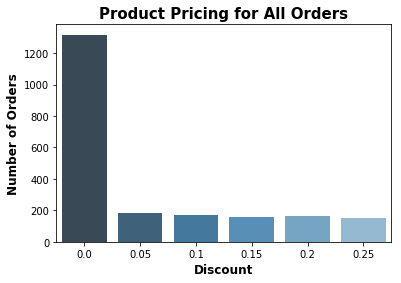

In [200]:
discount_value_counts_sig = discount_value_counts[discount_value_counts.Quantity > 10]
sns.barplot(discount_value_counts_sig.Discount, discount_value_counts_sig.Quantity, palette='Blues_d')
plt.title('Product Pricing for All Orders', fontweight='bold', fontsize=15)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)
plt.xlabel('Discount', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Orders: Discounted Products')

Text(0, 0.5, 'Number of Orders')

Text(0.5, 0, 'Discount')

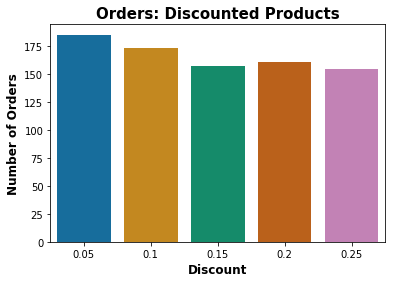

In [201]:
discount_value_counts_discount = discount_value_counts_sig[discount_value_counts_sig.Quantity < 1000]
sns.barplot(discount_value_counts_discount.Discount, discount_value_counts_discount.Quantity, palette='colorblind')
plt.title('Orders: Discounted Products', fontweight='bold', fontsize=15)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)
plt.xlabel('Discount', fontweight='bold', fontsize=12)

### Normality Test - Two-tailed - Statsmodels Normal Test

In [165]:
print('Normality of 5% discount', stats.normaltest(order_details[order_details.Discount == 0.05].Quantity))
print('Normality of 10% discount', stats.normaltest(order_details[order_details.Discount == 0.1].Quantity))
print('Normality of 15% discount', stats.normaltest(order_details[order_details.Discount == 0.15].Quantity))
print('Normality of 20% discount', stats.normaltest(order_details[order_details.Discount == 0.20].Quantity))
print('Normality of 25% discount', stats.normaltest(order_details[order_details.Discount == 0.25].Quantity))

Normality of 5% discount NormaltestResult(statistic=63.84242740591745, pvalue=1.3702286160643066e-14)
Normality of 10% discount NormaltestResult(statistic=98.50271035413209, pvalue=4.0776337983848464e-22)
Normality of 15% discount NormaltestResult(statistic=38.52550343019272, pvalue=4.308173885400061e-09)
Normality of 20% discount NormaltestResult(statistic=31.398997154435623, pvalue=1.519827852850104e-07)
Normality of 25% discount NormaltestResult(statistic=54.44887806745976, pvalue=1.5016763972075847e-12)


In [177]:
print('Variance of 5% discount', (order_details[order_details.Discount == 0.05].Quantity).var())
print('Variance of 10% discount', (order_details[order_details.Discount == 0.1].Quantity).var())
print('Variance of 15% discount', (order_details[order_details.Discount == 0.15].Quantity).var())
print('Variance of 20% discount', (order_details[order_details.Discount == 0.20].Quantity).var())
print('Variance of 25% discount', (order_details[order_details.Discount == 0.25].Quantity).var())

Variance of 5% discount 492.2933607520564
Variance of 10% discount 448.86792579647795
Variance of 15% discount 437.7760901518863
Variance of 20% discount 354.67437888198754
Variance of 25% discount 404.83732280791105


Based on the p-values above, these data sets do NOT represent normal distributions. They do exhibit similar variance. We will need to move forward with a Welch's T Test, as this specific test does not require the data meets the normality assumption

### Welch's T Test

In [170]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

In [173]:
welch_ttest(no_discount.Quantity, discount[discount.Discount == 0.05].Quantity)
welch_ttest(no_discount.Quantity, discount[discount.Discount == 0.10].Quantity)
welch_ttest(no_discount.Quantity, discount[discount.Discount == 0.15].Quantity)
welch_ttest(no_discount.Quantity, discount[discount.Discount == 0.20].Quantity)
welch_ttest(no_discount.Quantity, discount[discount.Discount == 0.25].Quantity)


 Welch's t-test= -3.7008 
 p-value = 0.0003 
 Welch-Satterthwaite Degrees of Freedom= 217.3603

 Welch's t-test= -2.0944 
 p-value = 0.0375 
 Welch-Satterthwaite Degrees of Freedom= 204.0260

 Welch's t-test= -3.8357 
 p-value = 0.0002 
 Welch-Satterthwaite Degrees of Freedom= 182.9771

 Welch's t-test= -3.4021 
 p-value = 0.0008 
 Welch-Satterthwaite Degrees of Freedom= 195.3279

 Welch's t-test= -3.8573 
 p-value = 0.0002 
 Welch-Satterthwaite Degrees of Freedom= 181.1251


__Conclusion__
<br>
All p-values from the T-Tests conducted for each of the major discount levels compared to non-discount orders are below the alpha threshold 0.05. So at each of these discount levels, we can reject the null hypothesis and assume the alternative hypothesis. These discount levels effect the average quantity of products per order.

-----------------

# Evaluating Our Sales Team

## Question 2a
__Do the members of our sales team perform equally in terms of the quantity of products sold? How about total sales?__

$H_{o}$: All nine members of the sales team have equal performance in terms of selling products, measured by quantity.

$H_{a}$: Certain members of the sales team perform better and some perform worse than the rest of the team resulting in more or fewer products sold.

__How:__ Test our hypotheses with a two-tail test accounting for a difference in number of products sold amongst the 9 employees on the sales team.
<br>
__Tables:__ Employees, Orders, Order Details, Products
<br>
__Features:__ Quantity, EmployeeId_1, EmployeeId_2, EmployeeId_3, EmployeeId_4, EmployeeId_5, EmployeeId_6, EmployeeId_7, EmployeeId_8, EmployeeId_9

### Data Wrangling
Consolidating data from Employees, Orders, Order Details, and Products tables

Altering column names to match primary keys for related tables

In [61]:
employees.columns = ['EmployeeId', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate',
       'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country',
       'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath']

In [62]:
orders.columns = ['OrderId', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']

In [63]:
products.columns = ['ProductId', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued']

Merge Employees, Orders, Order Details, and Products

In [64]:
employees_orders = pd.merge(employees,
                           orders,
                           on='EmployeeId')
employees_orders_order_details = pd.merge(employees_orders,
                                         order_details,
                                         on='OrderId')
employees_orders_order_details_products = pd.merge(employees_orders_order_details,
                                                  products,
                                                  on=['ProductId', 'UnitPrice'])

Calculate Total Sale for all orders by multiplying the unit price by quantity sold and subtracting the % discount. Then create a new feature Total_Sale to capture that value for each order.

In [65]:
employees_orders_order_details_products['Total_Sale'] = (employees_orders_order_details_products.UnitPrice 
* employees_orders_order_details_products.Quantity * (1-employees_orders_order_details_products.Discount))

In [212]:
employees_orders_order_details_products.columns

Index(['EmployeeId', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy',
       'BirthDate', 'HireDate', 'Address', 'City', 'Region', 'PostalCode',
       'Country', 'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo',
       'PhotoPath', 'OrderId', 'CustomerId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry', 'Id',
       'ProductId', 'UnitPrice', 'Quantity', 'Discount', 'Discount_bin',
       'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit',
       'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued'],
      dtype='object')

In [240]:
employees_orders_order_details_products[employees_orders_order_details_products.EmployeeId == 5].HireDate.unique()
employees_orders_order_details_products[employees_orders_order_details_products.EmployeeId == 5].FirstName.unique()
employees_orders_order_details_products[employees_orders_order_details_products.EmployeeId == 5].OrderDate.unique()

array(['2025-10-17'], dtype=object)

array(['Steven'], dtype=object)

array(['2013-09-02', '2014-02-20', '2014-01-20', '2014-02-06',
       '2013-08-29', '2014-02-03', '2013-07-22', '2013-05-27',
       '2013-06-16', '2013-11-05', '2014-01-02', '2014-03-17',
       '2014-02-04', '2013-09-19', '2013-10-22', '2012-07-04',
       '2013-06-20', '2013-08-28', '2014-01-09', '2014-04-22',
       '2014-02-05', '2013-10-21', '2014-01-26', '2013-12-02',
       '2013-05-07', '2014-03-03', '2013-10-29'], dtype=object)

In [241]:
import time
ex_array_time = ['2013-09-02', '2014-02-20', '2014-01-20', '2014-02-06',
       '2013-08-29', '2014-02-03', '2013-07-22', '2013-05-27',
       '2013-06-16', '2013-11-05', '2014-01-02', '2014-03-17',
       '2014-02-04', '2013-09-19', '2013-10-22', '2012-07-04',
       '2013-06-20', '2013-08-28', '2014-01-09', '2014-04-22',
       '2014-02-05', '2013-10-21', '2014-01-26', '2013-12-02',
       '2013-05-07', '2014-03-03', '2013-10-29']
ex_array_time.sort(key=lambda x: time.mktime(time.strptime(x,"%Y-%m-%d")))
ex_array_time

['2012-07-04',
 '2013-05-07',
 '2013-05-27',
 '2013-06-16',
 '2013-06-20',
 '2013-07-22',
 '2013-08-28',
 '2013-08-29',
 '2013-09-02',
 '2013-09-19',
 '2013-10-21',
 '2013-10-22',
 '2013-10-29',
 '2013-11-05',
 '2013-12-02',
 '2014-01-02',
 '2014-01-09',
 '2014-01-20',
 '2014-01-26',
 '2014-02-03',
 '2014-02-04',
 '2014-02-05',
 '2014-02-06',
 '2014-02-20',
 '2014-03-03',
 '2014-03-17',
 '2014-04-22']

## Employee Tenure
<br>
All employees, with the exception of Steven, have been selling food products for a little more than a year, therefore the total sale and total quantity of products sold can be compared. (Steven has been with the company and actively selling for 8 months longer than the rest of the group, and his numbers are still the lowest)

Use one-hot encoding for all of the EmployeeIds in order to convert the categorical feature into a numerical feature to use with our ANOVA Tables.

In [66]:
one_hot_employeeId = (pd.get_dummies(employees_orders_order_details_products, 
                                      columns = ["EmployeeId"]))

In [67]:
print('Janet: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_3 == 1].Total_Sale), 2))
print('Nancy: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_1 == 1].Total_Sale), 2))
print('Margaret: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_4 == 1].Total_Sale), 2))
print('Andrew: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_2 == 1].Total_Sale), 2))
print('Robert: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_7 == 1].Total_Sale), 2))
print('Laura: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_8 == 1].Total_Sale), 2))
print('Anne: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_9 == 1].Total_Sale), 2))
print('Michael: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_6 == 1].Total_Sale), 2))
print('Steven: $', round(sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_5 == 1].Total_Sale), 2))

Janet: $ 154666.63
Nancy: $ 141941.01
Margaret: $ 140336.79
Andrew: $ 137291.92
Robert: $ 88825.14
Laura: $ 85937.84
Anne: $ 64941.57
Michael: $ 53371.08
Steven: $ 48061.96


In [68]:
print('Janet:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_3 == 1].Quantity))
print('Nancy:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_1 == 1].Quantity))
print('Margaret:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_4 == 1].Quantity))
print('Andrew:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_2 == 1].Quantity))
print('Robert:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_7 == 1].Quantity))
print('Laura:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_8 == 1].Quantity))
print('Anne:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_9 == 1].Quantity))
print('Michael:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_6 == 1].Quantity))
print('Steven:', sum(one_hot_employeeId[one_hot_employeeId.EmployeeId_5 == 1].Quantity))

Janet: 5661
Nancy: 5445
Margaret: 5767
Andrew: 4553
Robert: 3501
Laura: 3980
Anne: 1884
Michael: 2308
Steven: 2075


In [69]:
emp_names_array = ['Janet', 'Nancy', 'Margaret', 'Andrew', 'Robert', 'Laura', 'Anne', 'Michael', 'Steven']
emp_total_sale_array = [154666.63, 141941.01, 140336.79, 137291.92, 88825.14, 85937.84, 64941.57, 53371.08, 48061.96]
emp_total_quant_array = [5661, 5445, 5767, 4553, 3501, 3980, 1884, 2308, 2075]

In [70]:
emp_dictionary_2 = dict(zip(emp_names_array, emp_total_quant_array))
emp_dictionary = dict(zip(emp_names_array, emp_total_sale_array))

In [71]:
df_employees_sales_quant_1 = pd.DataFrame.from_dict(emp_dictionary_2, orient='index').reset_index()
df_employees_sales_quant_1.columns = ['Name', 'Total_Products_Sold']

In [72]:
df_employees_sales_quant = pd.DataFrame.from_dict(emp_dictionary, orient='index').reset_index()
df_employees_sales_quant.columns = ['Name', 'Total_Sale']

In [73]:
combined_df_employees_quant_sale = pd.merge(df_employees_sales_quant_1, df_employees_sales_quant, on='Name')

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Employeee Performance: Total Products Sold')

Text(0.5, 0, 'Name')

Text(0, 0.5, 'Total Products Sold')

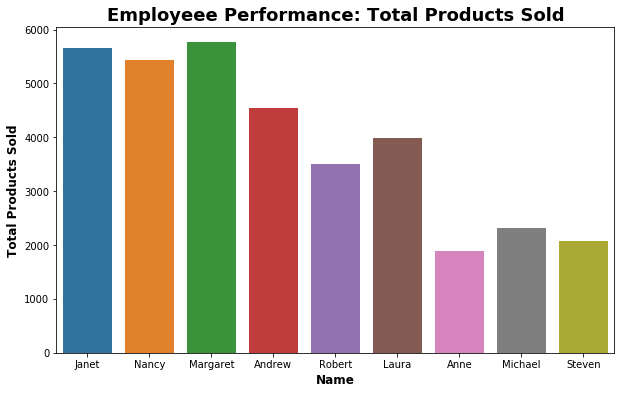

In [74]:
plt.figure(figsize=(10,6))
sns.barplot(combined_df_employees_quant_sale.Name, combined_df_employees_quant_sale.Total_Products_Sold)
plt.title('Employeee Performance: Total Products Sold', fontsize=18, fontweight='bold')
plt.xlabel('Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Products Sold', fontsize=12, fontweight='bold')

__Visualization Analysis__
<br>We can clearly see from the graph above that there are differences between each employee's amount of product sold. Janet, Nancy, and Margaret are the top three sales people generating the largest volume of products sold, all above 5000 units. While we see Anne, Michael, and Steven at the bottom.

__ANOVA Table__

In [75]:
formula = "Quantity ~ C(EmployeeId_1) + C(EmployeeId_2) + C(EmployeeId_3) + C(EmployeeId_4) + C(EmployeeId_5) + C(EmployeeId_6)\
+ C(EmployeeId_7) + C(EmployeeId_8) + C(EmployeeId_9)"
           
lm = ols(formula, one_hot_employeeId).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                        sum_sq      df          F    PR(>F)
C(EmployeeId_1)     124.127133     1.0   0.333205  0.563865
C(EmployeeId_2)    2609.367032     1.0   7.004538  0.008216
C(EmployeeId_3)    3815.342297     1.0  10.241836  0.001402
C(EmployeeId_4)      68.158204     1.0   0.182963  0.668901
C(EmployeeId_5)    1571.298127     1.0   4.217964  0.040173
C(EmployeeId_6)     135.056642     1.0   0.362544  0.547189
C(EmployeeId_7)    5379.028249     1.0  14.439366  0.000151
C(EmployeeId_8)    1090.625367     1.0   2.927655  0.087282
C(EmployeeId_9)      80.919383     1.0   0.217219  0.641236
Residual         554317.557745  1488.0        NaN       NaN


__Conclusion__

Based on the above ANOVA test, we see varied results among the set of employees. EmployeeId 2, 3, 5, and 7 (Andrew, Janet, Steven, and Robert) all resulted in p-values below the alpha threshold of 0.05. So the probability that this data is a result of random circumstance (and we should accept the null hypothesis) is less than 5%. Therefore, we can conclude that their quantities of products sold are significant, rejecting the null hypothesis and accepting the alternate hypothesis: employee performance varies in terms of quantity of products sold.

------------------------------------------------------

## Question 2b
__Do the members of our sales team perform equally in terms total sales?__

$H_{o}$: All nine members of the sales team have equal performance in terms of selling products, measured by total sale.

$H_{a}$: Certain members of the sales team perform better and some perform worse than the rest of the team resulting in a greater or lesser amount of total products sold.

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the total sale of products sld amongst the 9 employees on the sales team.
<br>
__Tables:__ Employees, Orders, Order Details, Products
<br>
__Features:__ Total_Sale, EmployeeId_1, EmployeeId_2, EmployeeId_3, EmployeeId_4, EmployeeId_5, EmployeeId_6, EmployeeId_7, EmployeeId_8, EmployeeId_9

For total sale, we can take the same approach as we did above comparing employee performance based on the Quantity of products sold, substituting Total_Sale into our ANOVA Table calculation with our one-hot encoded employeeId features.

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Employeee Performance: Total Sale')

Text(0.5, 0, 'Name')

Text(0, 0.5, 'Total Sale')

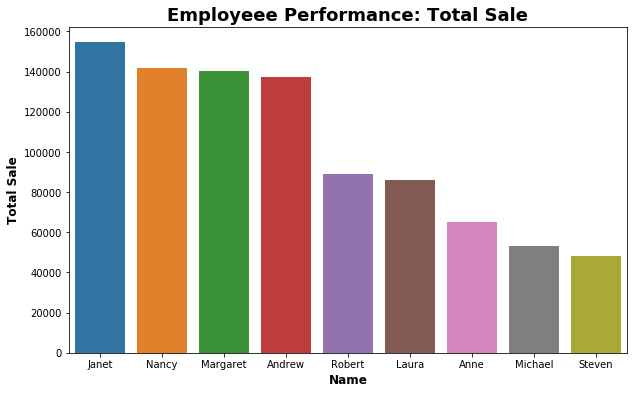

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(combined_df_employees_quant_sale.Name, combined_df_employees_quant_sale.Total_Sale)
plt.title('Employeee Performance: Total Sale', fontsize=18, fontweight='bold')
plt.xlabel('Name', fontsize=12, fontweight='bold')
plt.ylabel('Total Sale', fontsize=12, fontweight='bold')

__Visualization Analysis__
<br>From this bar chart, we again clearly see that each employee generated different gross profits from their sales orders. Janet, Nancy, and Margaret are again in the top three of total sales generated, all above 130,000 dollars. We again see Anne, Michael, and Steven at the bottom.

__ANOVA Table__

In [77]:
formula = "Total_Sale ~ C(EmployeeId_1) + C(EmployeeId_2) + C(EmployeeId_3) + C(EmployeeId_4) + C(EmployeeId_5) + C(EmployeeId_6)\
+ C(EmployeeId_7) + C(EmployeeId_8) + C(EmployeeId_9)"
           
lm = ols(formula, one_hot_employeeId).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                       sum_sq      df         F    PR(>F)
C(EmployeeId_1)  6.373875e+04     1.0  0.062078  0.803275
C(EmployeeId_2)  7.474497e+06     1.0  7.279800  0.007052
C(EmployeeId_3)  4.250815e+06     1.0  4.140089  0.042056
C(EmployeeId_4)  2.001221e+05     1.0  0.194909  0.658926
C(EmployeeId_5)  8.358050e+04     1.0  0.081403  0.775444
C(EmployeeId_6)  1.021894e+06     1.0  0.995276  0.318619
C(EmployeeId_7)  2.735335e+06     1.0  2.664085  0.102848
C(EmployeeId_8)  3.764771e+05     1.0  0.366671  0.544917
C(EmployeeId_9)  4.277415e+06     1.0  4.165996  0.041419
Residual         1.527796e+09  1488.0       NaN       NaN


__Conclusion__

Based on the above ANOVA test, we again see varied results among the set of employees. This time, EmployeeId 2, 3, and 9 (Andrew, Janet, and Anne) all resulted in p-values below the alpha threshold of 0.05. Therefore, we can conclude that their total sales figures are significant, thus we can reject the null hypothesis that all employees perform equally in terms of amount ($) total sold. These results match what we saw in our visualizations above.

__Quantity vs. Total Sale Performance Comparison__
<br>Our two ANOVA Tests produced different results when comparing employee performance based on quantity of products sold and total sale. Employees 2 and 3 (Andrew and Janet) were the two shared results between the two tests with p-values below the alpha threshold. The deltas we see are with the employee 5 and 7 results: low enough p-values for quantity of products sold but not for total_sale AND employee 9: low enough p-value for total_sale but not for quantity of products sold.

--------

# Customer Buying Trends

## Question 3
__Are reorder levels effective indicators of popular products?__

$H_{o}$: Reorder levels have no impact on the number of customer orders for a particular product.

$H_{a}$: The magnitude of reorders impacts the number of orders for a particular product.

__Hypothesis Testing Type__: Two-Tailed

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the number of customer orders for products based on reorder level.
<br>
__Tables:__ Products, Employees, Customers, Orders, Order Details, Categories
<br>
__Features:__ ReorderLevel, Quantity

__Control Group__: Orders of products with no reorder level
<br>
__Experimental Group__: Positive reorder level products

### Data Wrangling
Tables: Products, Employees, Customers, Orders, Order Details, Categories

In [78]:
products.ReorderLevel.describe()

count    77.000000
mean     12.467532
std      10.931105
min       0.000000
25%       0.000000
50%      10.000000
75%      25.000000
max      30.000000
Name: ReorderLevel, dtype: float64

In [79]:
categories.columns = ['CategoryId', 'CategoryName', 'Description']

In [264]:
employees_orders_order_details_products_categories.ReorderLevel.unique()

array([ 5,  0, 15, 20, 30, 10, 25])

In [80]:
employees_orders_order_details_products_categories = pd.merge(employees_orders_order_details_products,
                                                   categories,
                                                   on='CategoryId')

In [245]:
sum(employees_orders_order_details_products_categories.Quantity.unique())

2213

In [244]:
employees_orders_order_details_products_categories['Quantity'].head()

0    10
1     6
2    28
3    10
4     4
Name: Quantity, dtype: int64

In [265]:
reorder_value_counts = pd.DataFrame(employees_orders_order_details_products_categories.Discount.value_counts())
reorder_value_counts = reorder_value_counts.reset_index()
reorder_value_counts.columns = ['Reorder_Level', 'Quantity']
reorder_value_counts.head(10)

,Reorder_Level,Quantity
0,0.00,915
1,0.05,136
2,0.25,115
3,0.15,111
4,0.20,107
5,0.10,105
6,0.03,3
7,0.02,2
8,0.04,1
9,0.06,1


<Figure size 432x216 with 0 Axes>

Text(0.5, 1.0, 'All Orders Reorder Levels')

Text(0.5, 0, 'Reorder Level')

Text(0, 0.5, 'Number of Orders')

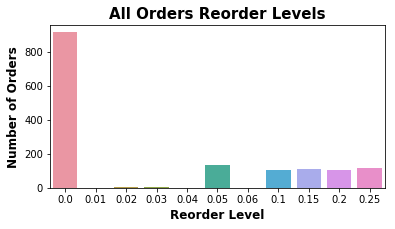

In [267]:
plt.figure(figsize=(6,3))
sns.barplot(reorder_value_counts.Reorder_Level, reorder_value_counts.Quantity)
plt.title('All Orders Reorder Levels', fontweight='bold', fontsize=15)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=12)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)

In [304]:
experimental_high_impact_products = employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel > 0]
control_low_impact_products = employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 0]

In [289]:
employees_orders_order_details_products.ReorderLevel.value_counts()

0     489
25    193
15    183
10    180
20    160
30    159
5     133
Name: ReorderLevel, dtype: int64

Text(0.5, 1.0, 'All Orders: Reorder Level Distribution')

Text(0.5, 0, 'Reorder Level')

Text(0, 0.5, 'Number of Orders')

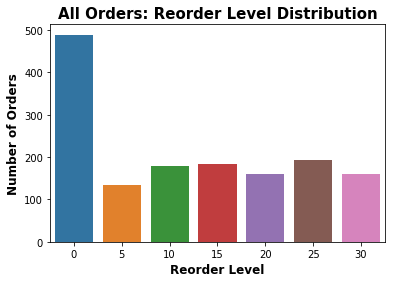

In [293]:
y = [489, 193, 183, 180, 160, 159, 133]
x = [0, 25, 15, 10, 20, 30, 5]
sns.barplot(x,y)
plt.title('All Orders: Reorder Level Distribution', fontweight='bold', fontsize=15)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=12)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=12)

In [297]:
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 0].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 5].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 10].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 15].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 20].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 25].Quantity)
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 30].Quantity)

11437

3153

4171

4321

3813

4488

3791

In [299]:
sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 0].Quantity) + sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 5].Quantity) + sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 10].Quantity)+sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 15].Quantity)+sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 20].Quantity)+sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 25].Quantity)+sum(employees_orders_order_details_products[employees_orders_order_details_products.ReorderLevel == 30].Quantity)

35174

Text(0.5, 1.0, 'Quantity of Product Across Reorder Levels')

Text(0.5, 0, 'Reorder Level')

Text(0, 0.5, 'Quantity')

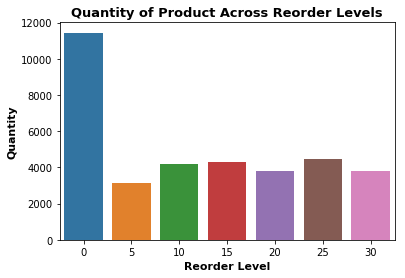

In [303]:
y = [11437,3153,4171,4321,3813,4488,3791]
x = [0, 5, 10, 15, 20, 25, 30]
sns.barplot(x,y)
plt.title('Quantity of Product Across Reorder Levels', fontweight='bold', fontsize=13)
plt.xlabel('Reorder Level', fontweight='bold', fontsize=11)
plt.ylabel('Quantity', fontweight='bold', fontsize=11)

__Variance__

In [306]:
print('Control Group Variance:', control_low_impact_products.Quantity.var())
print('Experimental Group Variance:', experimental_high_impact_products.Quantity.var())
print('Difference', abs(control_low_impact_products.Quantity.var() - experimental_high_impact_products.Quantity.var()))

Control Group Variance: 384.7175735022965
Experimental Group Variance: 369.951954374931
Difference 14.765619127365483


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Reorder Level Sample Distribution')

Text(0.5, 0, 'Reorder Level')

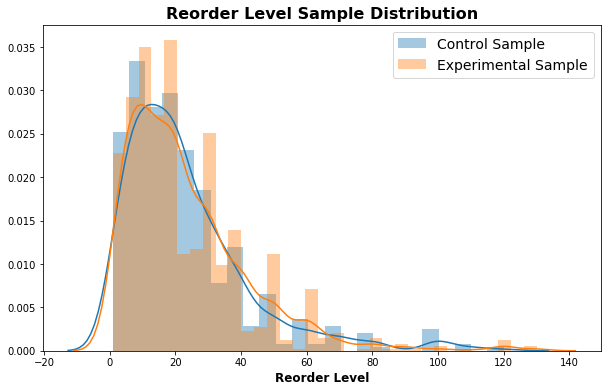

In [307]:
plt.figure(figsize=(10,6))
sns.distplot(control_low_impact_products.Quantity, label='Control Sample')
sns.distplot(experimental_high_impact_products.Quantity, label='Experimental Sample')
plt.title('Reorder Level Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Reorder Level', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

### Normality Test - Two-tailed - Statsmodels Normal Test

In [308]:
print('Normality of Control Group', stats.normaltest(control_low_impact_products.Quantity))
print('Normality of Experimental Group', stats.normaltest(experimental_high_impact_products.Quantity))

Normality of Control Group NormaltestResult(statistic=201.20025815444595, pvalue=2.041357473034165e-44)
Normality of Experimental Group NormaltestResult(statistic=404.56882747121597, pvalue=1.4092736754417282e-88)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

In [309]:
print("Cohen's d:", Cohens_d(np.array(experimental_high_impact_products.Quantity), 
                             np.array(control_low_impact_products.Quantity)))

Cohen's d: 0.0002621987471826185


## No Normality, Slight Difference in Variance, Small Effect Size - Resampling

#### Create a new Sample Distribution

In [310]:
control_sample = create_sample_distribution(control_low_impact_products.Quantity)
experimental_sample = create_sample_distribution(experimental_high_impact_products.Quantity)

__Sample Variance__

In [311]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 0.7360836678999999
Experimental Group Variance: 0.7208466012439999
Difference 0.015237066655999998


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Reorder Level Sample Distribution')

Text(0.5, 0, 'Reorder Level')

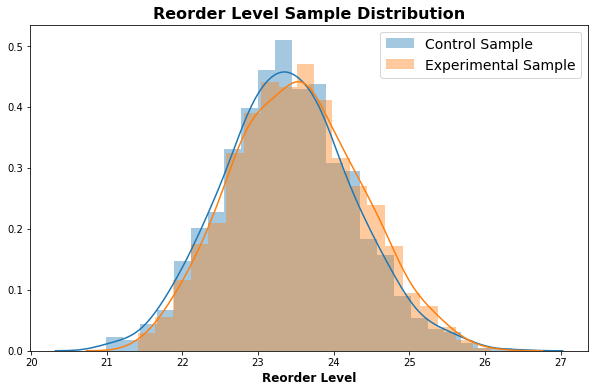

In [312]:
plt.figure(figsize=(10,6))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Reorder Level Sample Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Reorder Level', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions with minimal variance between the two groups (similar means consistent with Cohen's d value of 0.0003)

In [314]:
reordered_products = products[products.ReorderLevel > 0]
no_reorder_products = products[products.ReorderLevel == 0]

In [315]:
reorder_level_p_value = stats.ttest_ind(control_sample, experimental_sample)[1]
reorder_level_p_value

0.0014639765063184037

### Conclusion

With this low p-value below the alpha threshold of 0.05, we can reject the null hypothesis and accept the alternative. Reorder levels do affect the quantity of product sold.

## Testing Each Reorder Level

### Normality Test - Two-tailed - Statsmodels Normal Test

In [277]:
employees_orders_order_details_products.ReorderLevel.unique()

array([ 5,  0, 15, 25, 10, 20, 30])

In [278]:
print('Normality of 5% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 5].Quantity))

Normality of 5% reorder NormaltestResult(statistic=64.9754474677469, pvalue=7.776082378440185e-15)


In [279]:
print('Normality of 5% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 5].Quantity))
print('Normality of 10% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 10].Quantity))
print('Normality of 15% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 15].Quantity))
print('Normality of 20% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 20].Quantity))
print('Normality of 25% reorder', stats.normaltest(employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 25].Quantity))

Normality of 5% reorder NormaltestResult(statistic=64.9754474677469, pvalue=7.776082378440185e-15)
Normality of 10% reorder NormaltestResult(statistic=87.01070213276076, pvalue=1.276045318689801e-19)
Normality of 15% reorder NormaltestResult(statistic=78.3550422263691, pvalue=9.669828371043595e-18)
Normality of 20% reorder NormaltestResult(statistic=30.712958798059518, pvalue=2.1417350079449934e-07)
Normality of 25% reorder NormaltestResult(statistic=94.18274946140048, pvalue=3.535703262135695e-21)


Based on the p-values above, these data sets do NOT represent normal distributions. We will need to move forward with a Welch's T Test, as this specific test does not require the data meets the normality assumption

### Welch's T Test

In [317]:
welch_ttest(no_discount.Quantity, employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 5].Quantity)
welch_ttest(no_discount.Quantity, employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 10].Quantity)
welch_ttest(no_discount.Quantity, employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 15].Quantity)
welch_ttest(no_discount.Quantity, employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 20].Quantity)
welch_ttest(no_discount.Quantity, employees_orders_order_details_products[
    employees_orders_order_details_products.ReorderLevel == 25].Quantity)


 Welch's t-test= -1.0773 
 p-value = 0.2830 
 Welch-Satterthwaite Degrees of Freedom= 151.9183

 Welch's t-test= -0.9293 
 p-value = 0.3538 
 Welch-Satterthwaite Degrees of Freedom= 218.0716

 Welch's t-test= -1.3332 
 p-value = 0.1838 
 Welch-Satterthwaite Degrees of Freedom= 231.8218

 Welch's t-test= -1.4667 
 p-value = 0.1440 
 Welch-Satterthwaite Degrees of Freedom= 201.1705

 Welch's t-test= -1.0213 
 p-value = 0.3082 
 Welch-Satterthwaite Degrees of Freedom= 237.9271


## Conclusion
<br>
All p-values from the T-Tests conducted for each of the major reorder levels are above the alpha threshold 0.05. So fail to reject the null hypothesis and therefore reject the alternative hypothesis. None of the positive reorder levels do not significantly effect the average quantity of products per order.

So, we have found that there is a statistical significance in the quantity of products sold between orders without any reorders and those with varying levels of reorders. However, there is not a significant difference between those positive reorder levels in relation to the quantity of products sold in those orders.

---------------------------------------------------------------------------------------------------------------------

# Shipping Efficiency - Freight Costs

## Question 4
__Does the region of the customer versus the region of the supplier impact the shipping prices associated with the freight for these orders?__

$H_{o}$: The region of the customer and supplier have no impact on the price that suppliers pay for shipping products to the customer (freight).

$H_{a}$: The region of the customer and supplier either increases or decreases the shipping cost of products (freight).

__Hypothesis Testing Type__: Two-Tailed

__How:__ Test our hypotheses with a two-tail test accounting for a difference in the number of customer orders for products based on reorder level.
<br>
__Tables:__ Products, Employees, Customers, Orders, Order Details, Categories
<br>
__Features:__ Freight, Quantity

__Control Group__: Orders between customer and supplier in different regions
<br>
__Experimental Group__: Orders between customer and supplier in the same region

### Data Wrangling
Combining tables to capture Customers, Customer Orders, Order Details, Products, and Suppliers

In [98]:
customers.columns = ['CustomerId', 'CompanyName', 'ContactName', 'ContactTitle', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'Phone', 'Fax']
suppliers.columns = ['SupplierId', 'CompanyName', 'ContactName', 'ContactTitle', 'Address', 'City',
       'Region', 'PostalCode', 'Country', 'Phone', 'Fax', 'HomePage']
suppliers.columns = ['SupplierId', 'CompanyName_Supplier', 'ContactName_Supplier', 'ContactTitle_Supplier', 
                     'Address_Supplier', 'City_Supplier', 'Region_Supplier', 'PostalCode_Supplier', 
                     'Country_Supplier', 'Phone_Supplier', 'Fax_Supplier', 'HomePage_Supplier']
customers.columns = ['CustomerId', 'CompanyName_Customer', 'ContactName_Customer', 'ContactTitle_Customer', 'Address_Customer',
       'City_Customer', 'Region_Customer', 'PostalCode_Customer', 'Country_Customer', 'Phone_Customer', 'Fax_Customer']

In [99]:
employees_orders = pd.merge(employees,
                           orders,
                           on='EmployeeId')

In [100]:
employees_orders_order_details = pd.merge(employees_orders,
                                         order_details,
                                         on='OrderId')

In [101]:
employees_orders_order_details_products = pd.merge(employees_orders_order_details,
                                                   products,
                                                   on=['ProductId', 'UnitPrice'])

In [102]:
employees_orders_order_details_products_customers = pd.merge(employees_orders_order_details_products,
        customers,
        on='CustomerId')

In [103]:
employees_orders_order_details_products_customers_suppliers = pd.merge(employees_orders_order_details_products_customers,
        suppliers,
        on='SupplierId')

## Regional Breakdown - Global Customers and Suppliers

In [104]:
employees_orders_order_details_products_customers_suppliers.Region_Customer.unique()

array(['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe'], dtype=object)

In [105]:
employees_orders_order_details_products_customers_suppliers.Region_Customer.value_counts()

Western Europe     505
North America      312
South America      212
British Isles      128
Northern Europe     98
Southern Europe     86
Scandinavia         50
Central America     32
Eastern Europe      14
Name: Region_Customer, dtype: int64

In [106]:
employees_orders_order_details_products_customers_suppliers.Region_Supplier.value_counts()

Western Europe     290
North America      285
Southern Europe    148
British Isles      148
Victoria           112
Northern Europe    109
Scandinavia        105
Eastern Asia        82
NSW                 69
South-East Asia     54
South America       35
Name: Region_Supplier, dtype: int64

In [107]:
counter=0
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    total_region_customers = len(employees_orders_order_details_products_customers_suppliers[
        employees_orders_order_details_products_customers_suppliers.Region_Customer == region])
    total_region_cust_suppliers = len(employees_orders_order_details_products_customers_suppliers[
        (employees_orders_order_details_products_customers_suppliers.Region_Customer == region) &
        (employees_orders_order_details_products_customers_suppliers.Region_Supplier == region)])
    counter = counter + total_region_cust_suppliers
    print('Total Customers in', region, ':', total_region_customers)
    print('Customer and Supplier in', region, ':', total_region_cust_suppliers,)
    print('% Both from ', region, ':', round(total_region_cust_suppliers/total_region_customers, 3))
    print('\n')
print('Total orders where the customer region matches the supplier: ', counter)

Total Customers in Western Europe : 505
Customer and Supplier in Western Europe : 110
% Both from  Western Europe : 0.218


Total Customers in North America : 312
Customer and Supplier in North America : 61
% Both from  North America : 0.196


Total Customers in South America : 212
Customer and Supplier in South America : 7
% Both from  South America : 0.033


Total Customers in Scandinavia : 50
Customer and Supplier in Scandinavia : 3
% Both from  Scandinavia : 0.06


Total Customers in Central America : 32
Customer and Supplier in Central America : 0
% Both from  Central America : 0.0


Total Customers in British Isles : 128
Customer and Supplier in British Isles : 11
% Both from  British Isles : 0.086


Total Customers in Northern Europe : 98
Customer and Supplier in Northern Europe : 10
% Both from  Northern Europe : 0.102


Total Customers in Southern Europe : 86
Customer and Supplier in Southern Europe : 6
% Both from  Southern Europe : 0.07


Total Customers in Eastern Europe : 

In [108]:
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    print(region, '$', round(employees_orders_order_details_products_customers_suppliers[
        employees_orders_order_details_products_customers_suppliers.Region_Customer == region].Freight.mean(), 2))

Western Europe $ 133.64
North America $ 129.83
South America $ 52.17
Scandinavia $ 44.96
Central America $ 50.41
British Isles $ 94.87
Northern Europe $ 123.54
Southern Europe $ 47.44
Eastern Europe $ 32.4


In [109]:
for region in employees_orders_order_details_products_customers_suppliers.Region_Customer.unique():
    print(region, '$', round(employees_orders_order_details_products_customers_suppliers[
        (employees_orders_order_details_products_customers_suppliers.Region_Customer == region) &
        (employees_orders_order_details_products_customers_suppliers.Region_Supplier == region)].Freight.mean(), 2))

Western Europe $ 165.26
North America $ 107.96
South America $ 43.13
Scandinavia $ 17.96
Central America $ nan
British Isles $ 70.91
Northern Europe $ 143.03
Southern Europe $ 57.72
Eastern Europe $ nan


In [110]:
same_region_df_1 = employees_orders_order_details_products_customers_suppliers.copy(deep=True)

In [111]:
same_region_df_1.Region_Customer.unique()

array(['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe'], dtype=object)

In [112]:
region_array = ['Western Europe', 'North America', 'South America', 'Scandinavia',
       'Central America', 'British Isles', 'Northern Europe',
       'Southern Europe', 'Eastern Europe']
diff_region_array = [133.64, 129.83, 52.17, 44.96, 50.41, 94.87, 123.54, 47.44, 32.4]
same_region_array = [165.26, 107.96, 43.13, 17.96, 0, 70.91, 143.03, 57.72, 0]

In [113]:
reg_dictionary_2 = dict(zip(region_array, diff_region_array))
reg_dictionary = dict(zip(region_array, same_region_array))

In [114]:
df_diff_region_freight = pd.DataFrame.from_dict(reg_dictionary_2, orient='index').reset_index()
df_diff_region_freight.columns = ['Region', 'Different_Region_Freight']

In [115]:
df_same_region_freight = pd.DataFrame.from_dict(reg_dictionary, orient='index').reset_index()
df_same_region_freight.columns = ['Region', 'Same_Region_Freight']

In [116]:
combined_diff_and_same_region_freight = pd.merge(df_diff_region_freight, df_same_region_freight, on='Region')

### Visualizing the Data - Freight Costs within and between global regions

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Global Shipping to Different Regions: Freight Costs')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Freight Cost ($)')

[Text(0, 0, 'Western Europe'),
 Text(0, 0, 'North America'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Scandinavia'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'British Isles'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Eastern Europe')]

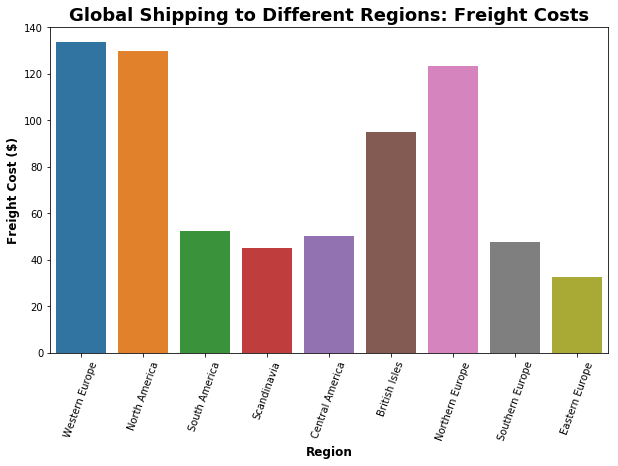

In [117]:
plt.figure(figsize=(10,6))
plot_diff_region = sns.barplot(combined_diff_and_same_region_freight.Region, combined_diff_and_same_region_freight.Different_Region_Freight)
plt.title('Global Shipping to Different Regions: Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Freight Cost ($)', fontsize=12, fontweight='bold')
plot_diff_region.set_xticklabels(plot_diff_region.get_xticklabels(), rotation=70)

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Shipping Within Regions: Freight Costs')

Text(0.5, 0, 'Region')

Text(0, 0.5, 'Freight Cost ($)')

[Text(0, 0, 'Western Europe'),
 Text(0, 0, 'North America'),
 Text(0, 0, 'South America'),
 Text(0, 0, 'Scandinavia'),
 Text(0, 0, 'Central America'),
 Text(0, 0, 'British Isles'),
 Text(0, 0, 'Northern Europe'),
 Text(0, 0, 'Southern Europe'),
 Text(0, 0, 'Eastern Europe')]

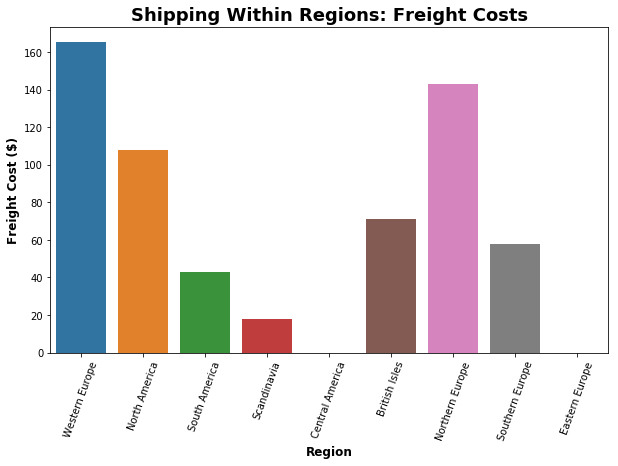

In [118]:
plt.figure(figsize=(10,6))
plot_same_region = sns.barplot(combined_diff_and_same_region_freight.Region, 
                               combined_diff_and_same_region_freight.Same_Region_Freight)
plt.title('Shipping Within Regions: Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Freight Cost ($)', fontsize=12, fontweight='bold')
plot_same_region.set_xticklabels(plot_same_region.get_xticklabels(), rotation=70)

In [119]:
same_region_df_1['Same_Region'] = np.where(same_region_df_1['Region_Customer'] == 
                                           same_region_df_1['Region_Supplier'], 1, 0)

In [120]:
same_region_df_1.Same_Region.value_counts()

0    1229
1     208
Name: Same_Region, dtype: int64

__Analysis__
<br>We see a significant difference in sample size between the control group (orders where the customer and supplier reside in different regions) and the experimental group (customers and suppliers hail from the same region). We will need to resample to bring the values closer to one another in order for our comparison to have any merit.

In [121]:
diff_region_control_group = same_region_df_1[same_region_df_1.Same_Region == 0]
same_region_experimental_group = same_region_df_1[same_region_df_1.Same_Region == 1]
diff_region_control_group_freight = diff_region_control_group.Freight
same_region_experimental_group_freight = same_region_experimental_group.Freight

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Supplier and Customer Region Freight Costs')

Text(0.5, 0, 'Freight ($)')

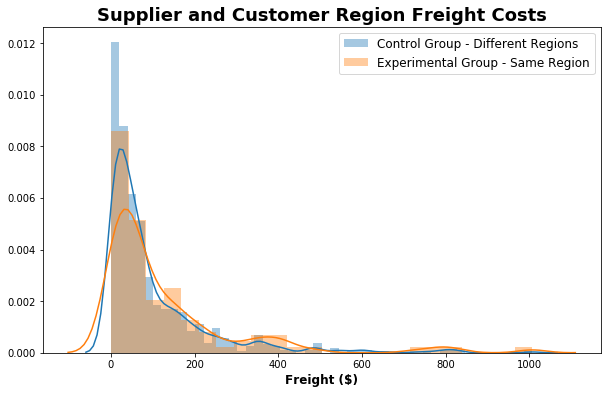

In [123]:
plt.figure(figsize=(10,6))
sns.distplot(diff_region_control_group_freight, label='Control Group - Different Regions')
sns.distplot(same_region_experimental_group_freight, label='Experimental Group - Same Region')
plt.title('Supplier and Customer Region Freight Costs', fontsize=18, fontweight='bold')
plt.xlabel('Freight ($)', fontsize=12, fontweight='bold')
plt.legend(fontsize=12)

__Distribution Analysis__
<br>The above distribution plot shows heavy right skewedness for both the control and experimental group. We will likely need to explore transformation or resampling in order to fullfill the normality assumption to move forward.

### Normality Test - Two-tailed - Statsmodels Normal Test

In [124]:
print('Normality of Control Group', stats.normaltest(diff_region_control_group_freight))
print('Normality of Experimental Group', stats.normaltest(same_region_experimental_group_freight))

Normality of Control Group NormaltestResult(statistic=782.3457933967768, pvalue=1.3054778085715278e-170)
Normality of Experimental Group NormaltestResult(statistic=134.5411215999535, pvalue=6.092094760649916e-30)


The results of the normalality tests above fall in line with the distribution plot above. Very small p-values provide additional evidence that the distributions are not normal, thus we cannot fulfill that assumption to move forward.

### Effect Size

In [125]:
print("Cohen's d:", Cohens_d(np.array(same_region_experimental_group_freight), 
                             np.array(diff_region_control_group_freight)))

Cohen's d: 0.012351686825689384


There is a very small Cohen's d value for effect size between the control and experimental groups.

#### Create a new Sample Distribution

In [128]:
control_sample = create_sample_distribution(diff_region_control_group_freight)
experimental_sample = create_sample_distribution(same_region_experimental_group_freight)

__Sample Variance__

In [129]:
print('Control Group Variance:', np.array(control_sample).var())
print('Experimental Group Variance:', np.array(experimental_sample).var())
print('Difference', abs(np.array(control_sample).var() - np.array(experimental_sample).var()))

Control Group Variance: 37.158071247266676
Experimental Group Variance: 62.94893448083788
Difference 25.7908632335712


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Freight Cost: Supplier and Customer Regions')

Text(0.5, 0, 'Freight ($)')

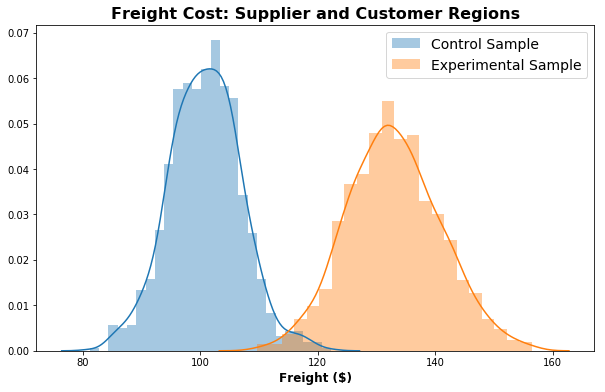

In [130]:
plt.figure(figsize=(10,6))
sns.distplot(control_sample, label='Control Sample')
sns.distplot(experimental_sample, label='Experimental Sample')
plt.title('Freight Cost: Supplier and Customer Regions', fontsize=16, fontweight='bold')
plt.xlabel('Freight ($)', fontsize=12, fontweight='bold')
plt.legend(fontsize=14)

__Distribution Analysis__
We now see distributions for the control and experimental samples resembling normal distributions with now significant variance between the two groups.

In [263]:
stats.ttest_ind(control_sample, experimental_sample)

Ttest_indResult(statistic=-101.27279082345785, pvalue=0.0)

__Conclusion__

Based on the above statistical t-test, we see a p-value within the alpha threshold of 0.05. Thus we can reject the null hypothesis and accept the alternative hypothesis, freight costs will differ between orders that occur within the same region (customer and supplier) vs differing global regions. I actually found that prices are largely higher for orders within the same region, which is interesting because it generally means that the product travels a shorter distance. But as I stated before, there are number of other conditions that will impact freight costs for shipping products worldwide that these results do not yet capture.

---------------------------------------------------------------------------------------------------------------------

-----------